In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

## Литература
* Лоуcон Ч., Хенсон P. - Численное решение задач метода наименьших квадратов. М.: Наука, 1986 (страница 124)

In [2]:
A = np.random.rand(5, 2)
b = np.random.rand(5)

Result = namedtuple('Result', ('x', 'fun', 'grad'))

In [3]:
class NNLS:
    def __init__(self, A, b):
        self.A = np.asarray(A)
        self.b = np.asarray(b)
        self._x = np.zeros(A.shape[1])
        self.P = np.zeros_like(self._x, dtype=bool)
        self.w = np.empty_like(self._x)
        self.recalc_w = True
        self.t = None
    
    def loss(self, x):
        return np.linalg.norm(self.A @ x - self.b)**2
    
    def result(self):
        return Result(self.x, self.loss(self.x), self.w)
    
    @staticmethod
    def argmax_index(x, idx):
        i = np.argmax(x[idx])
        return np.arange(x.size)[idx][i]
    
    def solve(self):
        if self.recalc_w:
            self.w[:] = self.negative_grad(self.x)
        # -------------------v
        if np.all(self.w <= 1e-8) or np.all(self.P):
        # -------------------^
            return self.result()
        self.t = self.argmax_index(self.w, self.Z)
        self.P[self.t] = True
        self.inner_solve()
        return self.solve()

    def inner_solve(self):
        z = np.zeros_like(self.x)
        z[self.P] = np.linalg.lstsq(self.A[:, self.P], self.b)[0]
        if z[self.t] <= 0:
            self.w[self.t] = 0
            self.recalc_w = False
            return
        else:
            self.recalc_w = True
        if np.all(z[self.P] > 0):
            self.x = z
            return
        i_z_nonpos = (z <= 0) & self.P
        alpha = np.min(self.x[i_z_nonpos] / (self.x[i_z_nonpos] - z[i_z_nonpos]))
        self.x = self.x + alpha * (z - self.x)
        self.inner_solve()
    
    def negative_grad(self, x):
        return self.A.T @ (self.b - self.A @ x)
    
    @property
    def x(self):
        return self._x
    
    @x.setter
    def x(self, v):
        self._x[:] = v
        self._x[self._x <= 0] = 0
        self.P[self._x == 0] = False
    
    @property
    def Z(self):
        return ~self.P

In [4]:
print(A)
print(b)
print('##############', np.linalg.lstsq(A, b)[0])
n = NNLS(A, b)
print(n.solve())

[[0.6149139  0.22637262]
 [0.26872393 0.67178044]
 [0.03344973 0.73961822]
 [0.13028468 0.40546428]
 [0.12866752 0.10216123]]
[0.38799924 0.28341126 0.15712361 0.129042   0.65542764]
############## [0.71659255 0.17935333]
Result(x=array([0.71659255, 0.17935333]), fun=0.3078639938500168, grad=array([6.93889390e-17, 1.73472348e-16]))


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


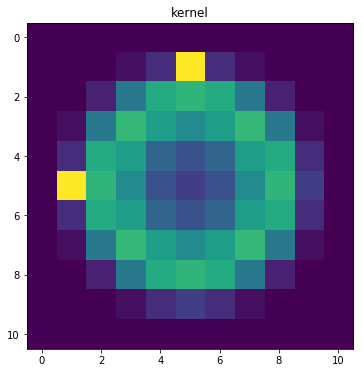

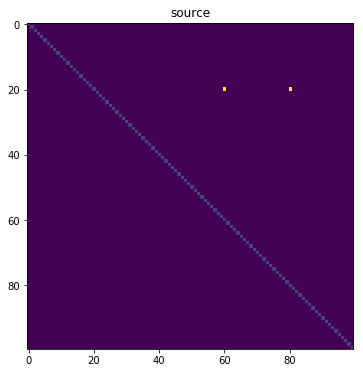

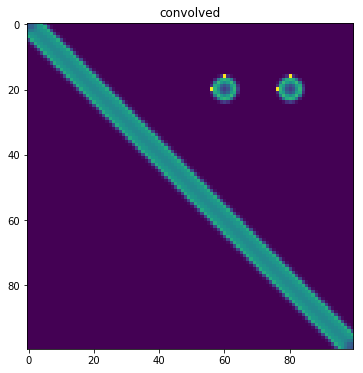

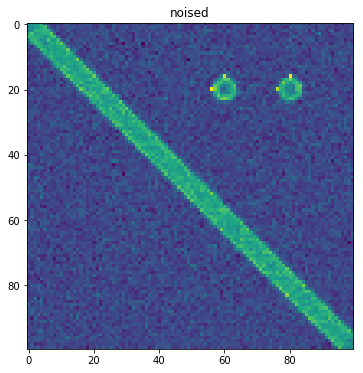

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import convolve

def show_img(array, title=''):
    plt.figure(figsize=(6,6))
    plt.title(title)
    plt.imshow(array)

kernel_size = 11
sigma = 5
x, y = np.indices((kernel_size, kernel_size)) - kernel_size // 2
kernel = np.exp(-(x**2 + y**2 - 8)**2 / (2 * sigma**2))
kernel[1,5] = kernel[5,1] = 1.5
show_img(kernel, 'kernel')

source = np.zeros((100, 100))
source[np.diag_indices(source.shape[0])] = 1.0
source[20, 80] = source[20, 60] = 5.0
show_img(source, 'source')

convolved = convolve(source, kernel, mode='same')
show_img(convolved, 'convolved')

noised = convolved + np.random.normal(scale=0.5, size=source.shape)
show_img(noised, 'noised')

In [6]:
a = np.zeros(convolved.shape + source.shape)
for c_idx in np.ndindex(convolved.shape):
    k_idx1 = tuple([x - size // 2 for size, x in zip(kernel.shape, c_idx)])
    k_idx2 = tuple([x + size // 2 + 1 for size, x in zip(kernel.shape, c_idx)])
    dst_idx1 = np.max(np.vstack([k_idx1, np.zeros_like(k_idx1)]), axis=0)
    dst_idx2 = np.min(np.vstack([k_idx2, convolved.shape]), axis=0)
    src_idx1 = dst_idx1 - k_idx1
    src_idx2 = dst_idx2 - k_idx2 + np.asarray(kernel.shape)
    a[c_idx[0], c_idx[1], dst_idx1[0]:dst_idx2[0], dst_idx1[1]:dst_idx2[1]] = kernel[src_idx1[0]:src_idx2[0], src_idx1[1]:src_idx2[1]]
a = a.reshape(convolved.size, source.size)
b = noised.reshape(-1)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


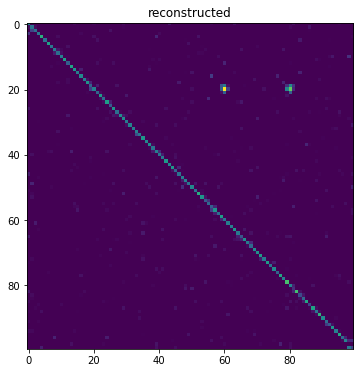

In [7]:
n = NNLS(a, b)
result = n.solve()
show_img(result.x.reshape(source.shape), 'reconstructed')

In [8]:
from scipy.optimize import lsq_linear
from scipy.sparse.linalg import LinearOperator

In [9]:
shape = noised.shape

def mm(v):
    bias = v[0]
    c = convolve(v[1:].reshape(shape), kernel, mode='same', method='fft') + bias
    return c.reshape(-1)
    
def rmm(v):
    c = convolve(v.reshape(shape), kernel[::-1,::-1], mode='same', method='fft')
    return np.concatenate([[v.sum(),], c.reshape(-1)])

b = noised.reshape(-1)
x_size = np.prod(shape) + 1
A = LinearOperator((b.shape[0], x_size), matvec=mm, rmatvec=rmm)

In [10]:
res = lsq_linear(A, b, tol=1e-5, lsmr_tol='auto', max_iter=400, verbose=2, bounds=(0, np.inf))

   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         1.9994e+06                                    4.42e+04    
       1         1.9390e+06      6.05e+04       3.60e-01       5.25e+03    
       2         5.8639e+05      1.35e+06       2.95e+01       1.01e+03    
       3         1.5098e+05      4.35e+05       1.74e+01       2.39e+02    
       4         3.9462e+04      1.12e+05       9.08e+00       8.30e+01    
       5         1.1795e+04      2.77e+04       4.74e+00       4.09e+01    
       6         5.6023e+03      6.19e+03       2.70e+00       3.00e+01    
       7         3.5230e+03      2.08e+03       1.37e+00       2.68e+01    
       8         3.3118e+03      2.11e+02       4.67e-01       2.27e+01    
       9         2.6325e+03      6.79e+02       1.02e+00       1.93e+01    
      10         2.2012e+03      4.31e+02       6.08e-01       1.63e+01    
      11         2.1162e+03      8.50e+01       2.58e-01       1.57e+01    
      12    

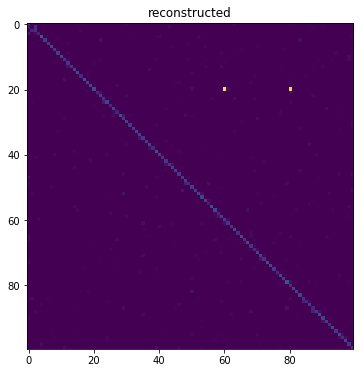

In [11]:
show_img(res.x[1:].reshape(shape), 'reconstructed')

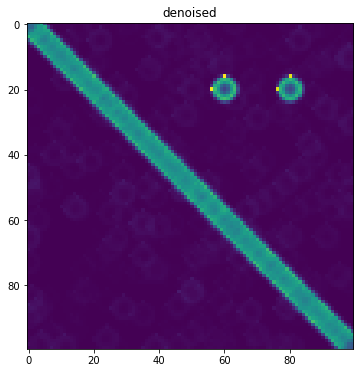

In [12]:
c = convolve(res.x[1:].reshape(shape), kernel, mode='same', method='fft')

show_img(c, 'denoised')